# Random Forest CHALLENGE

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

import ds_useful as ds

[My Useful Data Science Functions](https://github.com/cobyoram/python-for-data-scientists/blob/master/ds_useful.py)

In [2]:
try:
    raw_solar = pd.read_csv('energy_dataset.csv')
    raw_weather = pd.read_csv('weather_features.csv')
except FileNotFoundError as e:
    print(e)
    print('Attempting to read datasets from online csv files on Github')
    raw_solar = pd.read_csv('https://github.com/cobyoram/Thinkful_capstone_1/blob/master/energy_dataset.csv')
    raw_weather = pd.read_csv('https://github.com/cobyoram/Thinkful_capstone_1/blob/master/weather_features.csv')

This is the pair of datasets I used for my first capstone. Since I think I am going to use it for my second capstone, I figured it'd be worth implementing into this challeng. This time, I want to try to predict the solar production based off of just weather information.

In [3]:
raw_solar.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [4]:
raw_solar[['generation solar', 'forecast solar day ahead']]

,generation solar,forecast solar day ahead
0,49.0,17.0
1,50.0,16.0
2,50.0,8.0
3,50.0,2.0
4,42.0,9.0
...,...,...
35059,85.0,96.0
35060,33.0,51.0
35061,31.0,36.0
35062,31.0,29.0


In [5]:
raw_weather.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

In [6]:
raw_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [7]:
for col in raw_weather.select_dtypes('object').columns:
    print(col, raw_weather[col].unique(), '\n')

dt_iso ['2015-01-01 00:00:00+01:00' '2015-01-01 01:00:00+01:00'
 '2015-01-01 02:00:00+01:00' ... '2018-12-31 21:00:00+01:00'
 '2018-12-31 22:00:00+01:00' '2018-12-31 23:00:00+01:00'] 

city_name ['Valencia' 'Madrid' 'Bilbao' ' Barcelona' 'Seville'] 

weather_main ['clear' 'clouds' 'rain' 'mist' 'thunderstorm' 'drizzle' 'fog' 'smoke'
 'haze' 'snow' 'dust' 'squall'] 

weather_description ['sky is clear' 'few clouds' 'scattered clouds' 'broken clouds'
 'overcast clouds' 'light rain' 'moderate rain' 'heavy intensity rain'
 'mist' 'heavy intensity shower rain' 'shower rain' 'very heavy rain'
 'thunderstorm with heavy rain' 'thunderstorm with light rain'
 'thunderstorm with rain' 'proximity thunderstorm' 'thunderstorm'
 'light intensity shower rain' 'light intensity drizzle' 'fog' 'drizzle'
 'smoke' 'heavy intensity drizzle' 'haze' 'proximity shower rain'
 'light intensity drizzle rain' 'light snow' 'rain and snow'
 'light rain and snow' 'snow' 'light thunderstorm' 'heavy snow' 'sleet'
 'rai

In [8]:
raw_weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [9]:
ds.missingness_summary(raw_weather)

weather_icon           0.0
wind_speed             0.0
city_name              0.0
temp                   0.0
temp_min               0.0
temp_max               0.0
pressure               0.0
humidity               0.0
wind_deg               0.0
weather_description    0.0
rain_1h                0.0
rain_3h                0.0
snow_3h                0.0
clouds_all             0.0
weather_id             0.0
weather_main           0.0
dt_iso                 0.0
dtype: float64

In [10]:
raw_solar.loc[raw_solar['generation solar'].isnull()]

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
99,2015-01-05 03:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,546.0,NaN,8233.0,21912.0,21182.0,35.20,59.68
108,2015-01-05 12:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3932.0,NaN,9258.0,23209.0,NaN,35.50,79.14
109,2015-01-05 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4236.0,NaN,9156.0,23725.0,NaN,36.80,73.95
110,2015-01-05 14:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4215.0,NaN,9072.0,23614.0,NaN,32.50,71.93
111,2015-01-05 15:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4050.0,NaN,8779.0,22381.0,NaN,30.00,71.50
112,2015-01-05 16:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3728.0,NaN,8426.0,21371.0,NaN,30.00,71.85
113,2015-01-05 17:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3175.0,NaN,7946.0,20760.0,NaN,30.60,80.53
451,2015-01-19 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,91.0,NaN,6434.0,38642.0,39304.0,70.01,88.95
452,2015-01-19 20:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,28.0,NaN,6907.0,38758.0,39262.0,69.00,87.94
643,2015-01-27 19:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,182.0,NaN,9807.0,38968.0,38335.0,66.00,83.97


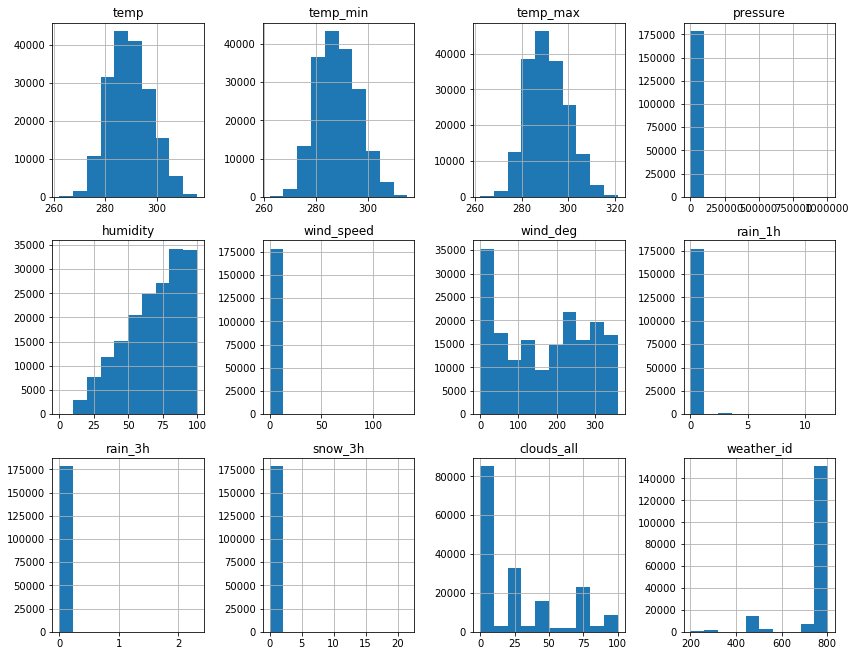

In [11]:
def plot_num(df, column_name):
    df[column_name].hist()

ds.make_subplots(raw_weather.select_dtypes('number'), plot_num)

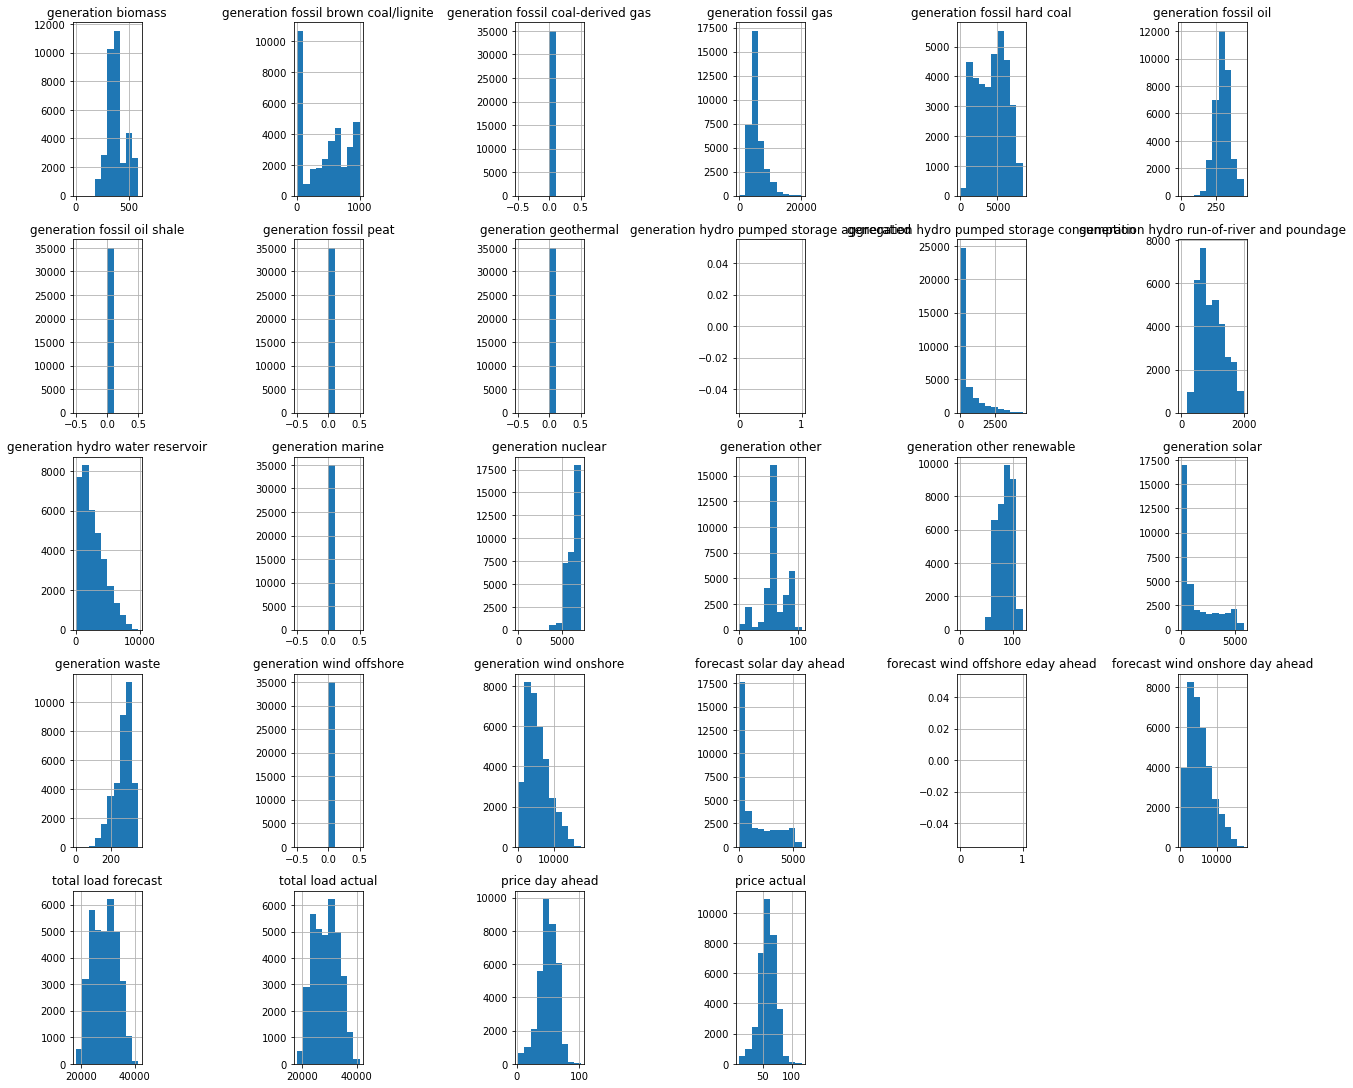

In [12]:
ds.make_subplots(raw_solar.select_dtypes('number'), plot_num)

First we'll grab just our target variable from the energy dataset. We want to predict the solar production at any hour using weather data, so we only need the 'generation solar' and 'time' columns ('time' will be used to join the datasets together)

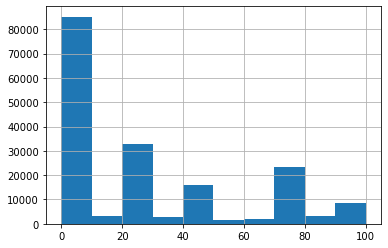

In [13]:
raw_weather['clouds_all'].hist()

In [14]:
# The data is provided in the correct timezone, but we want to centralize the data on the local timezone
# We drop the '+##:##' from each timestamp reading in both datasets 
raw_weather['dt_iso'] = raw_weather['dt_iso'].str.replace('\+[0-9][0-9]:[0-9][0-9]', '', regex=True)
raw_solar['time'] = raw_solar['time'].str.replace('\+[0-9][0-9]:[0-9][0-9]', '', regex=True)

raw_weather = raw_weather.rename({'dt_iso': 'time'}, axis=1)

In [15]:
# Make a new dataframe with just solar generation and time
time_solar = raw_solar[['time', 'generation solar']]

# Inputate the missing data for solar generation
time_solar = time_solar.interpolate()
ds.missingness_summary(time_solar)

generation solar    0.0
time                0.0
dtype: float64

In [16]:
# Add the solar data to the weather dataset
solar_weather = raw_weather.merge(time_solar, on='time')

In [17]:
solar_weather

,time,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,generation solar
0,2015-01-01 00:00:00,Valencia,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n,49.0
1,2015-01-01 00:00:00,Madrid,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n,49.0
2,2015-01-01 00:00:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,800,clear,sky is clear,01,49.0
3,2015-01-01 00:00:00,Barcelona,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,800,clear,sky is clear,01n,49.0
4,2015-01-01 00:00:00,Seville,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,800,clear,sky is clear,01n,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178431,2018-12-31 23:00:00,Valencia,279.140000,278.150000,280.150000,1029,75,2,300,0.0,0.0,0.0,0,800,clear,sky is clear,01n,31.0
178432,2018-12-31 23:00:00,Madrid,275.150000,275.150000,275.150000,1031,74,1,360,0.0,0.0,0.0,0,800,clear,sky is clear,01n,31.0
178433,2018-12-31 23:00:00,Bilbao,275.600000,275.150000,276.150000,1034,93,2,100,0.0,0.0,0.0,0,800,clear,sky is clear,01n,31.0
178434,2018-12-31 23:00:00,Barcelona,280.130000,277.150000,283.150000,1028,100,5,310,0.0,0.0,0.0,0,800,clear,sky is clear,01n,31.0


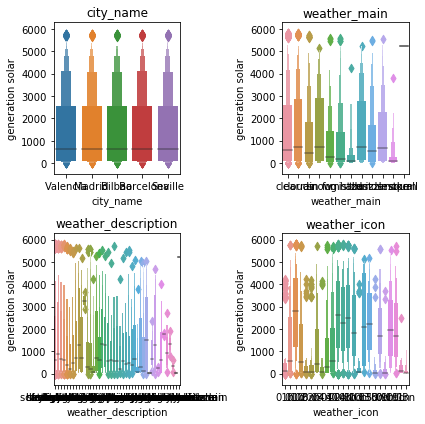

In [18]:
def plot_cat(df, col, target):
    sns.boxenplot(x=col, y=target, data=df)
    
ds.make_subplots(solar_weather.drop('time', axis=1).select_dtypes('object'), plot_cat, [solar_weather['generation solar']])

In [19]:
drop_cols = ['weather_description', 'weather_icon', 'weather_id']

solar_weather.drop(drop_cols, axis=1, inplace=True)

In [20]:
solar_weather.head()

,time,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_main,generation solar
0,2015-01-01 00:00:00,Valencia,270.475000,270.475000,270.475000,1001,77,1,62,0.0,0.0,0.0,0,clear,49.0
1,2015-01-01 00:00:00,Madrid,267.325000,267.325000,267.325000,971,63,1,309,0.0,0.0,0.0,0,clear,49.0
2,2015-01-01 00:00:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0.0,0.0,0.0,0,clear,49.0
3,2015-01-01 00:00:00,Barcelona,281.625000,281.625000,281.625000,1035,100,7,58,0.0,0.0,0.0,0,clear,49.0
4,2015-01-01 00:00:00,Seville,273.375000,273.375000,273.375000,1039,75,1,21,0.0,0.0,0.0,0,clear,49.0


In [21]:
outliers = ds.outliers_summary(solar_weather)
outliers

rain_1h             10.867762
pressure             6.635432
wind_speed           1.359031
rain_3h              1.039588
temp_max             0.219126
temp_min             0.162523
snow_3h              0.149633
temp                 0.109843
humidity             0.035307
generation solar     0.000000
clouds_all           0.000000
wind_deg             0.000000
dtype: float64

In [22]:
# Look at the min and max for each column with outliers
meaningless_columns = []
for col in outliers.loc[outliers>0].index:
    min_val, max_val = ds.get_minmax_with_threshold(solar_weather[col], 1.5)
    print(col, min_val, max_val)
    if min_val == max_val:
        meaningless_columns.append(col)

rain_1h 0.0 0.0
pressure 999.5 1035.5
wind_speed -3.5 8.5
rain_3h 0.0 0.0
temp_max 265.9 315.9
temp_min 265.6245 310.5804999999999
snow_3h 0.0 0.0
temp 266.45000000000005 312.3699999999999
humidity 2.0 138.0


In [23]:
# Drop columns with all meaningful data outside the min and max
solar_weather.drop(meaningless_columns, axis=1, inplace=True)
solar_weather

,time,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,generation solar
0,2015-01-01 00:00:00,Valencia,270.475000,270.475000,270.475000,1001,77,1,62,0,clear,49.0
1,2015-01-01 00:00:00,Madrid,267.325000,267.325000,267.325000,971,63,1,309,0,clear,49.0
2,2015-01-01 00:00:00,Bilbao,269.657312,269.657312,269.657312,1036,97,0,226,0,clear,49.0
3,2015-01-01 00:00:00,Barcelona,281.625000,281.625000,281.625000,1035,100,7,58,0,clear,49.0
4,2015-01-01 00:00:00,Seville,273.375000,273.375000,273.375000,1039,75,1,21,0,clear,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...
178431,2018-12-31 23:00:00,Valencia,279.140000,278.150000,280.150000,1029,75,2,300,0,clear,31.0
178432,2018-12-31 23:00:00,Madrid,275.150000,275.150000,275.150000,1031,74,1,360,0,clear,31.0
178433,2018-12-31 23:00:00,Bilbao,275.600000,275.150000,276.150000,1034,93,2,100,0,clear,31.0
178434,2018-12-31 23:00:00,Barcelona,280.130000,277.150000,283.150000,1028,100,5,310,0,clear,31.0


In [24]:
outliers = ds.outliers_summary(solar_weather)
outliers

pressure            6.635432
wind_speed          1.359031
temp_max            0.219126
temp_min            0.162523
temp                0.109843
humidity            0.035307
generation solar    0.000000
clouds_all          0.000000
wind_deg            0.000000
dtype: float64

In [25]:
# Since we have a time-series, we will winsorize the outliers to keep them in the dataset.
for col in outliers.loc[outliers>0].index:
    percentiles = ds.get_percentiles(solar_weather, col, 1.5)
    stats.mstats.winsorize(solar_weather[col], percentiles, axis=0, inplace=True)
    
ds.outliers_summary(solar_weather)

generation solar    0.0
clouds_all          0.0
wind_deg            0.0
wind_speed          0.0
humidity            0.0
pressure            0.0
temp_max            0.0
temp_min            0.0
temp                0.0
dtype: float64

In [29]:
# make dummy variables for
dummies = pd.get_dummies(solar_weather.select_dtypes('object').drop('time', axis=1), drop_first=True)
dummies

,city_name_Bilbao,city_name_Madrid,city_name_Seville,city_name_Valencia,weather_main_clouds,weather_main_drizzle,weather_main_dust,weather_main_fog,weather_main_haze,weather_main_mist,weather_main_rain,weather_main_smoke,weather_main_snow,weather_main_squall,weather_main_thunderstorm
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178431,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
178432,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
178433,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
178434,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
# Join the numerical data back to the dummies
X = pd.concat([dummies, solar_weather.drop(['city_name', 'weather_main', 'time'], axis=1)], axis=1)
y = solar_weather['generation solar']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [46]:
dtr = DecisionTreeRegressor(
    max_features = 5,
    max_depth = 4)

dtr.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [53]:
tuned_parameters = {'max_features': [1,3,5,7,9,11], 'max_depth': [2,4,6,8]}

gs = GridSearchCV(dtr, param_grid=tuned_parameters, cv=5)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9496232398846282
{'max_depth': 8, 'max_features': 11}


In [55]:
rfr = RandomForestRegressor(max_features=5)

rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [57]:
tuned_parameters = {'max_features': [1,5,7,11], 'max_depth': [2,4,8]}

gs = GridSearchCV(rfr, param_grid=tuned_parameters, cv=5)
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.9976578515829807
{'max_depth': 8, 'max_features': 11}


In [61]:
import time

start_time = time.time()

dtr = DecisionTreeRegressor(max_features=11, max_depth=8)
dtr.fit(X_train, y_train)
print(dtr.score(X_test, y_test))
print(time.time() - start_time)

0.9974185433578283
0.3480982780456543


In [62]:
start_time = time.time()

rfr = RandomForestRegressor(max_features=11, max_depth=8)
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test))
print(time.time() - start_time)


0.9978999013343178
20.383467435836792
